# Narzędzie wizualizujące tworzenie grafu widoczności

## Konfiguracja


Poniższe narzędzie zostało zmodyfikowane, tak aby można było z niego korzystać w nowszych IDE, które nie wspierają `%matplotlib notebook`.
Aby korzystać z `%matplotlib widget` należy doinstalować pakiet `ipympl` np. za pomocą polecenia `pip install ipympl`. Jeżeli po zainstalowaniu będą występować błędy, należy korzystać z backendu `notebook`.

Wykorzystywane biblioteki:
- matplotlib
- numpy
- ipympl

Nowe funkcje:
- Dodanie do konstruktora klasy Scene argumentu `title`, który pozwala na ustawienie tytułu danej sceny
- Dodanie do konstruktora klasy Plot argumentu `title`, który pozwala na ustawienie tytułu wykresu / okna widżetu
- Dodanie możliwości definiowania własnych zakresów osi OX oraz OY dla wykresów (argumenty klasy Plot: `xlim` oraz `ylim` jako krotka dwuelementowa definiująca przedział, gdy zostanie podany tylko zakres dla jednej osi, druga oś będzie automatycznie skalowana)

Naprawione bugi:
- Naprawiono problem, gdy po utworzeniu nowego pustego wykresu, tworzyła się kopia poprzednio utworzonego (kopiowały się sceny z ostatniego obiektu plot)
- Poprawiono metodę zamykania figur (tworzony jest okrąg o środku pierwszego punktu i promieniu adekwatnym do zakresów osi)
- Nowo dodane figury, punkty, linie są zapisywane osobno dla każdej sceny
- Zmieniono wyświetlanie się punktów i linii (punkty wyświetlają się przed liniami)


In [14]:
# Wybór backendu matplotlib
# %matplotlib notebook
%matplotlib widget

# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.02

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes, xlim=[], ylim=[]):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = [[] for _ in range(len(scenes))]
        self.adding_lines = False
        self.added_lines = [[] for _ in range(len(scenes))]
        self.adding_rects = False
        self.added_rects = [[] for _ in range(len(scenes))]
        # DODANO: zapisz tytuł sceny
        self.scene_title = self.scenes[0].title if len(self.scenes) and self.scenes[0].title else ""
        # DODANO: ustawienie zakresów osi wykresu
        self.xlim = xlim
        self.ylim = ylim
        self.custom_axis = len(xlim) != 0 or len(ylim) != 0

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        # ADDED: Change scene title
        self.scene_title = self.scenes[self.i].title
        self.draw(autoscaling = not self.custom_axis)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        # ADDED: Change scene title
        self.scene_title = self.scenes[self.i].title
        self.draw(autoscaling = not self.custom_axis)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points[self.i].append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines[self.i].append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects[self.i].append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        return self.added_points[self.i]
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        return self.added_lines[self.i]
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        return self.added_rects[self.i]
  
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        return Scene(self.added_points[self.i], self.added_lines[self.i]+self.added_rects[self.i])


    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[self.i][-1].add_points([new_point])
            self.draw(autoscaling = False,hand_drawing=True)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[self.i][-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False,hand_drawing=True)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[self.i][-1].add((self.rect_points[-1], new_point))
                self.rect_points.append(new_point)
                self.draw(autoscaling = False,hand_drawing=True)
            elif len(self.rect_points) > 1:
                # DODANO: zmiana metody wykrywania zakończenia figury.
                # Teraz punkt self.rect_points[0] jest środkiem okręgu o promieniu TOLERANCE*(mediana zakresów wykresu)
                # Gdy użytkownik kliknie w obrębie tego okręgu, figura zostanie zamknięta
                if (new_point[0] - self.rect_points[0][0]) ** 2 + (new_point[1] - self.rect_points[0][1]) ** 2 <= (np.mean([self.ax.get_xlim()[1] - self.ax.get_xlim()[0], self.ax.get_ylim()[1]-self.ax.get_ylim()[0]])*TOLERANCE) ** 2:
                    self.added_rects[self.i][-1].add((self.rect_points[-1], self.rect_points[0]))
                    self.new_rect()
                else:    
                    self.added_rects[self.i][-1].add((self.rect_points[-1], new_point))
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False, hand_drawing=True)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True, hand_drawing = False):
        # DODANO: ustawienie zakresów osi wykresu
        autoscale_axis='both'
        if not autoscaling:
            if self.custom_axis:
                xlim = self.xlim  
                ylim = self.ylim  

            choose_autoscale_axis = [False, False] # [OX, OY]

            if not self.custom_axis or not self.xlim:
                xlim = self.ax.get_xlim()
                choose_autoscale_axis[0] = True
            
            if not self.custom_axis or not self.ylim:
                ylim = self.ax.get_ylim()
                choose_autoscale_axis[1] = True

            if choose_autoscale_axis == [True, False]:
                autoscale_axis = 'x'
                autoscaling = not hand_drawing
            if choose_autoscale_axis == [False, True]:
                autoscale_axis = 'y'
                autoscaling = not hand_drawing

        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points[self.i]):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs, zorder=3)
        for collection in (self.scenes[self.i].lines + self.added_lines[self.i] + self.added_rects[self.i]):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(enable=autoscaling, axis=autoscale_axis)

        if autoscale_axis == 'y':
            self.ax.set_xlim(xlim)

        if autoscale_axis == 'x':
            self.ax.set_ylim(ylim)
      
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
            
        # DODANO: tytuł sceny
        fig = plt.gcf() # Pobierz aktywne okno
        fig.suptitle(self.scene_title)
        
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [15]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[], title=""):
        self.points=points
        self.lines=lines
        # ADDED: Scene title
        self.title = '\n'+title if title != "" else ""

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [], points = [], lines = [], json = None, title="", xlim=[], ylim=[]):
        # DODANO: tytuł wykresu
        self.plot_title = title
        # DODANO: ustawienie zakresów osi wykresu
        self.xlim = xlim
        self.ylim = ylim
        self.is_not_custom_axis = len(xlim)==0 and len(ylim)==0

        # NAPRAWIONO: pobieranie scen z wcześniej utworzonego wykresu
        if not scenes:
            self.scenes = [Scene()]
        else:
            self.scenes = scenes

        if json is None:
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]], title=scene["title"]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        for scene in self.scenes:
            print(scene.title)
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines],
                          "title": scene.title[1:]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            result = self.callback.get_added_points()
            return result
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            result = self.callback.get_added_lines()
            return result

    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            result = self.callback.get_added_figure()
            return result

    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            result = self.callback.get_added_elements()
            return result

    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        # DODANO: tytuł wykresu
        fig = plt.figure(num=self.plot_title)
        # DODANO: ustawienie zakresów osi wykresu
        self.callback = _Button_callback(self.scenes, self.xlim, self.ylim)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        # DODANO: ustawienie zakresów osi wykresu
        self.callback.draw(self.is_not_custom_axis)
        

### Przykłady użycia

##### Proste rysowanie

Rysowanie prostego rysunku złożonego ze statycznych punktów i odcinków jest stosunkowo proste. Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje w konstruktorze listę obiektów `PointsCollection` jako parametr `points` oraz listę `LinesCollection` jako parametr `lines`. Następnie należy wywołać jego metodę `draw()`.

```python
plot = Plot(points=[PointsCollection([(1, 2), (3, 1.5), (2, -1)]),
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")],
            lines=[LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])
plot.draw()     
```

##### Rysunek dynamiczny

To narzędzie pozwala na wizualizację "rysunków dynamicznych", a więc takich, które składają się z wielu różnych obrazów. Może to być przydatne np. podczas wizualizacji kolejnych kroków danego algorytmu. Poszczególne klatki określane są jako obiekty `Scene`, które przyjmują listę `PointsCollection` oraz listę `LinesCollection` w swoim konstruktorze. Obiekt `Plot` przyjmuje w parametrze konstruktora `scenes` właśnie listę takich scen.

Na rysunku przyciski `Następny` i `Poprzedni` służą do nawigacji pomiędzy nimi.

```python
scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])], "Scene 1"), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])],"Scene 2")]

plot=Plot(scenes = scenes)
plot.draw()
```

##### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

```python
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.json: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()
```

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

```python 
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot(points=[PointsCollection([(-2,-1),(5,3)], color='red')])
plot1.draw()

plot2 = Plot([plot1.get_added_elements()])
plot2.draw()
```

## Dodatkowe biblioteki oraz funkcje

In [16]:
from functools import cmp_to_key # For creating custom sort function
from math import sqrt

def euclidean_distance(a: tuple[float,float],b: tuple[float,float]) -> float:
    """Calculate distance between point a and point b using Euclidean metric.

    :param tuple[float,float] a: First point
    :param tuple[float,float] b: Second point
    :return float: Distance between a and b
    """
    return sqrt((a[0] - b[0]) ** 2  + (a[1]-b[1]) ** 2)

def point_position(a: tuple[float,float], b:tuple[float,float], c:tuple[float,float], epsilon=1e-10) -> int:
    """Find position of a point c relative to segment ab using 3x3 matrix determinant. 

    :param tuple[float,float] a: First point of a segment/vector
    :param tuple[float,float] b: Second point of a segment/vector
    :param tuple[float,float] c: Point which is considered
    "param float epsilon: Tolerance for collinearity
    :return int: 1 if point lies on the left, 0 if is collinear, -1 if is on the right side of a segment ab.
    """

    # Calculate matrix
    matrix = [[],[],[]]
    matrix[0] = [a[0], a[1], 1]
    matrix[1] = [b[0], b[1], 1]
    matrix[2] = [c[0], c[1], 1]

    f1 = matrix[0][0] * matrix[1][1] * matrix[2][2]
    f2 = matrix[0][1] * matrix[1][2] * matrix[2][0]
    f3 = matrix[1][0] * matrix[2][1] * matrix[0][2]
    f4 = matrix[0][2] * matrix[1][1] * matrix[2][0]
    f5 = matrix[1][2] * matrix[2][1] * matrix[0][0]
    f6 = matrix[1][0] * matrix[0][1] * matrix[2][2]
    
    determinant = f1+f2+f3-f4-f5-f6

    # Return relative position

    # Point c is on the left side of segment ab
    if determinant > epsilon:
        return 1
    # Point c is collinear with segment ab
    elif -epsilon <= determinant <= epsilon:
        return 0
    # Point c is on the right side of segment ab
    else:
        return -1

## Terminologia

- $p$ - punkt aktualnie badany
- $w_i$ - punkt, który może być widoczny przez punkt $p$

## Algorytm sprawdzania, czy punkt $w_i$ jest widoczny przez $p$

## Algorytm wykrywania wierzchołków widocznych z punktu $p$

In [24]:
def sort_points_clockwise(p: tuple[float,float], w: list[tuple[float,float]], distance_function=euclidean_distance) -> list[tuple[float,float]]:
    """Sort points clockwise relative to OX axis angle which creates segment pw[i]. 
    This sorting method is the nearly the same as in Graham algorithm for finding convex hull: 
    We check if point p lies on the left or on the right side of segment w[i]w[j].

    :param tuple[float,float] p: Relative point
    :param list[tuple[float,float]] w_i: List of points to sort
    :param distance_function: Distance metric, defaults to euclidean_distance
    :return list[tuple[float,float]]: Sorted points list
    """
    def compare_fn(a: tuple[float,float], b: tuple[float,float]) -> int:
        point_pos = point_position(a, b, p)

        # a == b
        if point_pos == 0:
            # Compare distances from point p
            d1 = distance_function(p,a)
            d2 = distance_function(p,b)

            if d1 < d2:
                return -1
            elif d1 > d2:
                return 1
    
            return 0
        
        # a > b
        elif point_pos == 1:
            return 1
        
        # a < b
        else:
            return -1

    return sorted(w, key=cmp_to_key(compare_fn))



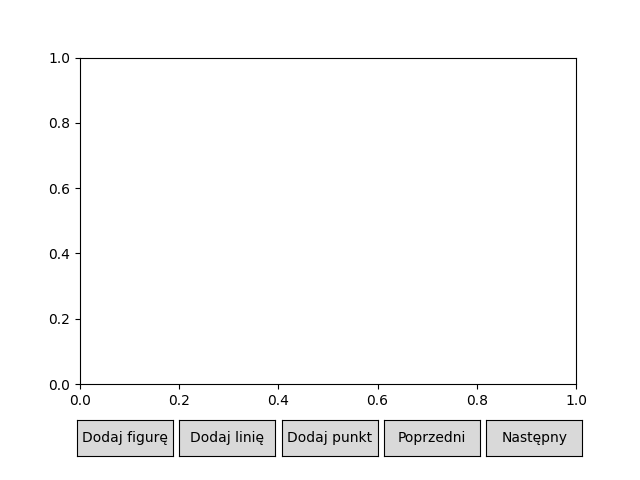

In [18]:
plot = Plot(xlim=[0,10], ylim=[0,10])
plot.draw()

In [23]:
p = plot.get_added_points()[0].points[0]
s = set()
for fig in plot.get_added_figure():
    for lines in fig.lines:
        s.add(lines[0])
        s.add(lines[1])

print(sort_points_clockwise(p,list(s)))

[(1.4113953805738881, 5.054698270909927), (2.39929860638034, 5.146610035615809), (1.3105889289609851, 6.77038454541973), (2.318653445090017, 6.8316590552236525)]


## Algorytm tworzenia grafu widoczności

## Algorytm wykrywania najkrótszej ścieżki w przestrzeni dwuwymiarowej z przeszkodami jako wielokąty

# Przykładowe działanie algorytmu